# Baseline Models: kNN and Majority Class

This notebook implements simple baseline models for fruit ripeness classification to compare against the CNN baseline.

## Baselines implemented:
1. **Majority Class**: Always predict the most frequent class
2. **k-Nearest Neighbors (kNN)**: Distance-based voting on raw pixel values

## Dataset:
- 9 classes: {fresh, rotten, unripe} × {apples, banana, oranges}
- Train/test split already provided in `datasetcopy/`

## Expected Results:
- Random baseline: ~11% accuracy (uniform random)
- Majority class: ~11-15% (depending on class imbalance)
- kNN on raw pixels: ~30-50%
- CNN (from baseline_cnn_pytorch.ipynb): **84.5%** ← our model to beat!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Dataset

Load images from the train/test folders. We'll resize to a smaller size (64×64) to:
- Reduce memory usage
- Speed up kNN (fewer dimensions)
- Keep it "simple" (low-res raw pixels)

In [2]:
# Configuration
DATA_ROOT = Path("../datasetcopy")  # Adjust if needed
TRAIN_DIR = DATA_ROOT / "train"
TEST_DIR = DATA_ROOT / "test"
IMAGE_SIZE = 64  # Resize to 64×64 for kNN (smaller = faster, less memory)
K_NEIGHBORS = 5  # Number of neighbors for kNN

# Class names (order will be alphabetical by folder name)
CLASS_NAMES = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
print(f"Classes ({len(CLASS_NAMES)}): {CLASS_NAMES}")

Classes (9): ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']


In [3]:
def load_images_from_folder(folder, class_names, image_size):
    """
    Load all images from a folder structure where each subfolder is a class.
    
    Returns:
        X: numpy array of shape (num_images, image_size, image_size, 3)
        y: numpy array of shape (num_images,) with class indices
        label_names: list of class names corresponding to indices
    """
    images = []
    labels = []
    
    for class_idx, class_name in enumerate(class_names):
        class_folder = folder / class_name
        if not class_folder.exists():
            print(f"Warning: {class_folder} does not exist, skipping...")
            continue
            
        image_files = list(class_folder.glob("*.png")) + list(class_folder.glob("*.jpg"))
        print(f"Loading {len(image_files)} images from {class_name}...")
        
        for img_path in tqdm(image_files, desc=class_name):
            try:
                # Load and resize image
                img = Image.open(img_path).convert('RGB')
                img = img.resize((image_size, image_size), Image.BILINEAR)
                img_array = np.array(img)
                
                images.append(img_array)
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels), class_names

In [5]:
# Load training data
print("\n=== Loading Training Data ===")
X_train, y_train, class_names = load_images_from_folder(TRAIN_DIR, CLASS_NAMES, IMAGE_SIZE)
print(f"\nTrain set: {X_train.shape[0]} images, shape: {X_train.shape}")
print(f"Labels shape: {y_train.shape}")

# Load test data
print("\n=== Loading Test Data ===")
X_test, y_test, _ = load_images_from_folder(TEST_DIR, CLASS_NAMES, IMAGE_SIZE)
print(f"\nTest set: {X_test.shape[0]} images, shape: {X_test.shape}")
print(f"Labels shape: {y_test.shape}")


=== Loading Training Data ===
Loading 1693 images from freshapples...


freshapples:   0%|          | 0/1693 [00:00<?, ?it/s]

freshapples: 100%|██████████| 1693/1693 [00:05<00:00, 313.00it/s]


Loading 1581 images from freshbanana...


freshbanana: 100%|██████████| 1581/1581 [00:05<00:00, 264.93it/s]


Loading 1466 images from freshoranges...


freshoranges: 100%|██████████| 1466/1466 [00:04<00:00, 328.05it/s]


Loading 2342 images from rottenapples...


rottenapples: 100%|██████████| 2342/2342 [00:07<00:00, 316.18it/s]


Loading 2224 images from rottenbanana...


rottenbanana: 100%|██████████| 2224/2224 [00:08<00:00, 256.79it/s]


Loading 1595 images from rottenoranges...


rottenoranges: 100%|██████████| 1595/1595 [00:05<00:00, 297.80it/s]


Loading 1934 images from unripe apple...


unripe apple: 100%|██████████| 1934/1934 [00:00<00:00, 2573.13it/s]


Loading 2097 images from unripe banana...


unripe banana: 100%|██████████| 2097/2097 [00:00<00:00, 2646.41it/s]


Loading 1285 images from unripe orange...


unripe orange: 100%|██████████| 1285/1285 [00:00<00:00, 2634.50it/s]




Train set: 16217 images, shape: (16217, 64, 64, 3)
Labels shape: (16217,)

=== Loading Test Data ===
Loading 395 images from freshapples...


freshapples: 100%|██████████| 395/395 [00:01<00:00, 317.79it/s]


Loading 381 images from freshbanana...


freshbanana: 100%|██████████| 381/381 [00:01<00:00, 265.39it/s]


Loading 388 images from freshoranges...


freshoranges: 100%|██████████| 388/388 [00:01<00:00, 326.87it/s]


Loading 601 images from rottenapples...


rottenapples: 100%|██████████| 601/601 [00:01<00:00, 320.92it/s]


Loading 530 images from rottenbanana...


rottenbanana: 100%|██████████| 530/530 [00:02<00:00, 250.69it/s]


Loading 403 images from rottenoranges...


rottenoranges: 100%|██████████| 403/403 [00:01<00:00, 300.66it/s]


Loading 371 images from unripe apple...


unripe apple: 100%|██████████| 371/371 [00:00<00:00, 2986.58it/s]


Loading 400 images from unripe banana...


unripe banana: 100%|██████████| 400/400 [00:00<00:00, 3099.57it/s]


Loading 270 images from unripe orange...


unripe orange: 100%|██████████| 270/270 [00:00<00:00, 3025.31it/s]


Test set: 3739 images, shape: (3739, 64, 64, 3)
Labels shape: (3739,)


In [6]:
# Check class distribution
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print("\n=== Class Distribution ===")
print("\nTraining set:")
for idx, name in enumerate(class_names):
    count = train_counts.get(idx, 0)
    pct = 100 * count / len(y_train)
    print(f"  {name:20s}: {count:4d} ({pct:5.1f}%)")

print("\nTest set:")
for idx, name in enumerate(class_names):
    count = test_counts.get(idx, 0)
    pct = 100 * count / len(y_test)
    print(f"  {name:20s}: {count:4d} ({pct:5.1f}%)")


=== Class Distribution ===

Training set:
  freshapples         : 1693 ( 10.4%)
  freshbanana         : 1581 (  9.7%)
  freshoranges        : 1466 (  9.0%)
  rottenapples        : 2342 ( 14.4%)
  rottenbanana        : 2224 ( 13.7%)
  rottenoranges       : 1595 (  9.8%)
  unripe apple        : 1934 ( 11.9%)
  unripe banana       : 2097 ( 12.9%)
  unripe orange       : 1285 (  7.9%)

Test set:
  freshapples         :  395 ( 10.6%)
  freshbanana         :  381 ( 10.2%)
  freshoranges        :  388 ( 10.4%)
  rottenapples        :  601 ( 16.1%)
  rottenbanana        :  530 ( 14.2%)
  rottenoranges       :  403 ( 10.8%)
  unripe apple        :  371 (  9.9%)
  unripe banana       :  400 ( 10.7%)
  unripe orange       :  270 (  7.2%)


## 2. Baseline 1: Majority Class

Always predict the most common class in the training set.

In [ ]:
# Find most common class
majority_class = train_counts.most_common(1)[0][0]
majority_class_name = class_names[majority_class]
majority_class_count = train_counts[majority_class]

print(f"Most common class: {majority_class_name} ({majority_class_count} samples)")

# Predict majority class for all test samples
y_pred_majority = np.full_like(y_test, majority_class)
majority_accuracy = accuracy_score(y_test, y_pred_majority)

print(f"\n{'='*60}")
print(f"MAJORITY CLASS BASELINE ACCURACY: {majority_accuracy:.4f} ({majority_accuracy*100:.2f}%)")
print(f"{'='*60}")

## 3. Baseline 2: k-Nearest Neighbors (kNN)

kNN algorithm:
1. Flatten each image to a 1D vector (64×64×3 = 12,288 dimensions)
2. Normalize pixel values to [0, 1]
3. For each test image:
   - Compute distance to all training images
   - Find K nearest neighbors
   - Vote: predict the most common class among those K neighbors

We'll use Euclidean distance (L2 norm).

In [7]:
# Flatten images to vectors and normalize
X_train_flat = X_train.reshape(X_train.shape[0], -1).astype(np.float32) / 255.0
X_test_flat = X_test.reshape(X_test.shape[0], -1).astype(np.float32) / 255.0

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")
print(f"Feature dimensionality: {X_train_flat.shape[1]} (= {IMAGE_SIZE}×{IMAGE_SIZE}×3)")

Flattened training data shape: (16217, 12288)
Flattened test data shape: (3739, 12288)
Feature dimensionality: 12288 (= 64×64×3)


In [8]:
# Train kNN classifier
print(f"\nTraining kNN with K={K_NEIGHBORS}...")
print("(This may take a minute as kNN has no training phase, but sklearn builds an index)")

knn = KNeighborsClassifier(
    n_neighbors=K_NEIGHBORS,
    metric='euclidean',  # L2 distance on raw pixels
    n_jobs=-1  # Use all CPU cores
)

knn.fit(X_train_flat, y_train)
print("kNN 'training' complete (indexed training data)")


Training kNN with K=5...
(This may take a minute as kNN has no training phase, but sklearn builds an index)
kNN 'training' complete (indexed training data)


In [9]:
# Predict on test set
print(f"\nPredicting on {len(X_test_flat)} test images...")
print("(This will be slower as kNN must compare each test image to all training images)")

y_pred_knn = knn.predict(X_test_flat)
knn_accuracy = accuracy_score(y_test, y_pred_knn)

print(f"\n{'='*60}")
print(f"kNN BASELINE ACCURACY (K={K_NEIGHBORS}): {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")
print(f"{'='*60}")


Predicting on 3739 test images...
(This will be slower as kNN must compare each test image to all training images)

kNN BASELINE ACCURACY (K=5): 0.6721 (67.21%)

kNN BASELINE ACCURACY (K=5): 0.6721 (67.21%)


## 4. Detailed Results & Comparison

In [10]:
# Print classification report for kNN
print("\n=== kNN Classification Report ===")
print(classification_report(y_test, y_pred_knn, target_names=class_names, digits=4))


=== kNN Classification Report ===
               precision    recall  f1-score   support

  freshapples     0.6444    0.7797    0.7056       395
  freshbanana     0.7137    0.8898    0.7921       381
 freshoranges     0.7198    0.8608    0.7840       388
 rottenapples     0.5992    0.7937    0.6829       601
 rottenbanana     0.8719    0.7321    0.7959       530
rottenoranges     0.7039    0.5782    0.6349       403
 unripe apple     0.5896    0.3989    0.4759       371
unripe banana     0.6714    0.3525    0.4623       400
unripe orange     0.5017    0.5370    0.5188       270

     accuracy                         0.6721      3739
    macro avg     0.6684    0.6581    0.6503      3739
 weighted avg     0.6778    0.6721    0.6618      3739



In [ ]:
# Calculate macro F1 score for kNN
knn_macro_f1 = f1_score(y_test, y_pred_knn, average='macro')
knn_weighted_f1 = f1_score(y_test, y_pred_knn, average='weighted')

print(f"\n{'='*60}")
print(f"kNN F1 SCORES (K={K_NEIGHBORS}):")
print(f"{'='*60}")
print(f"Macro F1 Score:    {knn_macro_f1:.4f} ({knn_macro_f1*100:.2f}%)")
print(f"Weighted F1 Score: {knn_weighted_f1:.4f} ({knn_weighted_f1*100:.2f}%)")
print(f"Test Accuracy:     {knn_accuracy:.4f} ({knn_accuracy*100:.2f}%)")
print(f"{'='*60}")
print(f"\nMacro F1: Unweighted average across all classes")
print(f"Weighted F1: Weighted by class support (accounts for imbalance)")

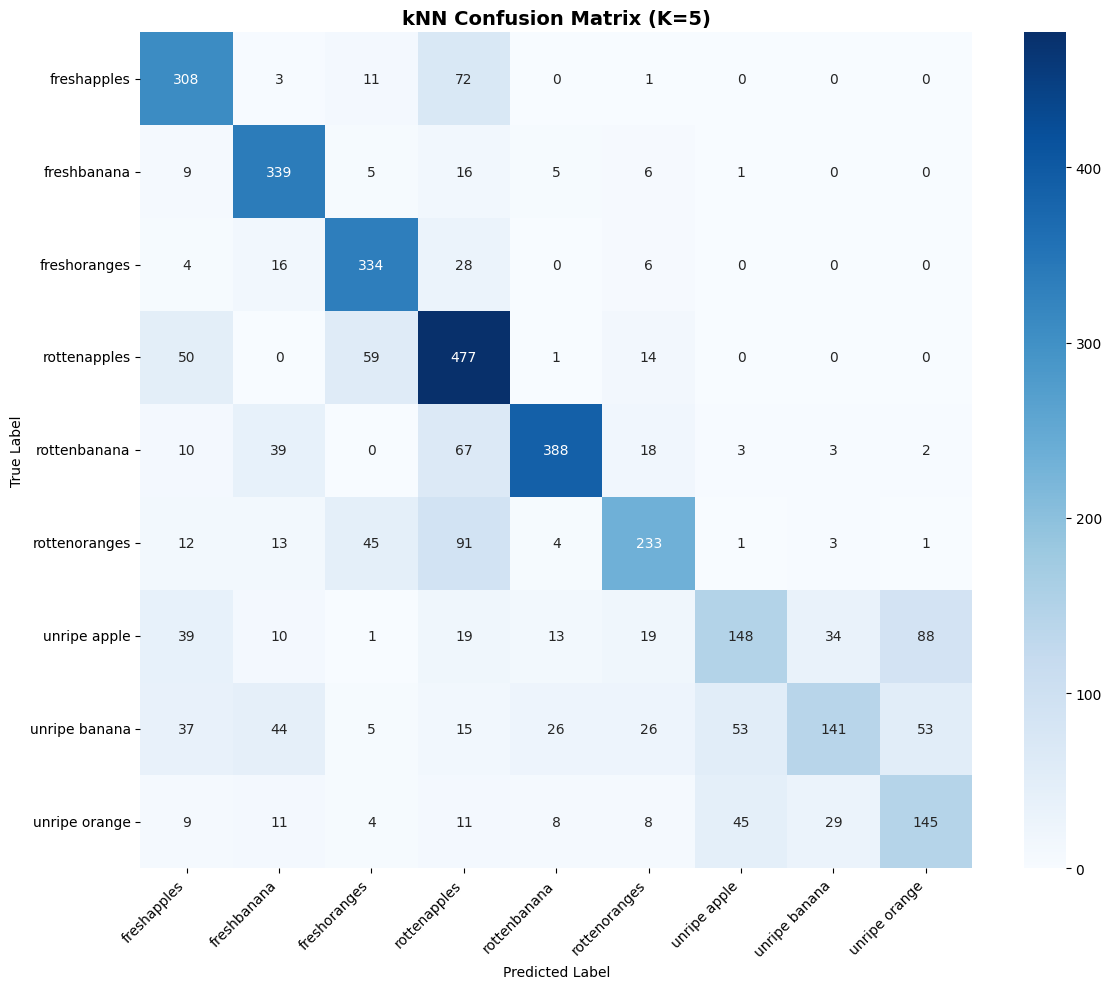

In [11]:
# Plot confusion matrix for kNN
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'kNN Confusion Matrix (K={K_NEIGHBORS})', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('artefacts/baseline_knn_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Summary comparison table
print("\n" + "="*70)
print("BASELINE COMPARISON SUMMARY")
print("="*70)
print(f"{'Model':<30s} {'Test Accuracy':<20s} {'Notes'}")
print("-"*70)
print(f"{'Random (uniform)':<30s} {0.111:<20.4f} {'(1/9 classes)'}")
print(f"{'Majority Class':<30s} {majority_accuracy:<20.4f} {'(always predict \"{majority_class_name}\")'}")
print(f"{'kNN (K={K_NEIGHBORS}, raw pixels)':<30s} {knn_accuracy:<20.4f} {'(Euclidean distance)'}")
print(f"{'CNN (from baseline_cnn_pytorch)':<30s} {0.845:<20.4f} {'(20 epochs, 224×224)'}")
print("="*70)

improvement_over_majority = (knn_accuracy - majority_accuracy) / majority_accuracy * 100
improvement_over_knn = (0.845 - knn_accuracy) / knn_accuracy * 100

print(f"\nkNN improvement over majority class: {improvement_over_majority:+.1f}%")
print(f"CNN improvement over kNN: {improvement_over_knn:+.1f}%")

SyntaxError: f-string expression part cannot include a backslash (1462573604.py, line 8)

## 5. Visualize Sample Predictions

Show some examples where kNN got it right vs. wrong.

In [13]:
# Find some correct and incorrect predictions
correct_mask = (y_pred_knn == y_test)
incorrect_mask = ~correct_mask

correct_indices = np.where(correct_mask)[0]
incorrect_indices = np.where(incorrect_mask)[0]

print(f"Correct predictions: {len(correct_indices)} ({100*len(correct_indices)/len(y_test):.1f}%)")
print(f"Incorrect predictions: {len(incorrect_indices)} ({100*len(incorrect_indices)/len(y_test):.1f}%)")

Correct predictions: 2513 (67.2%)
Incorrect predictions: 1226 (32.8%)


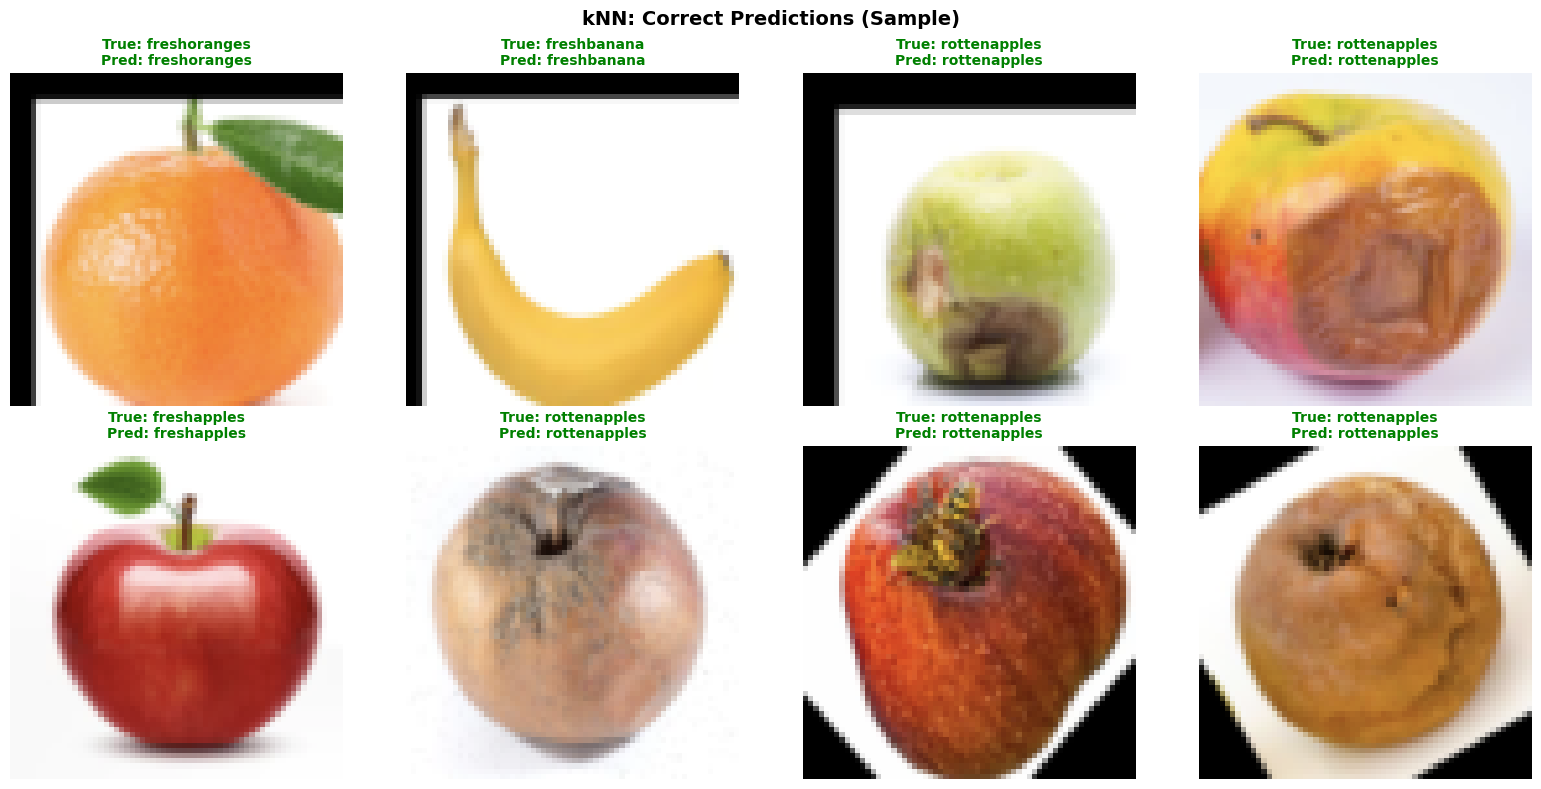

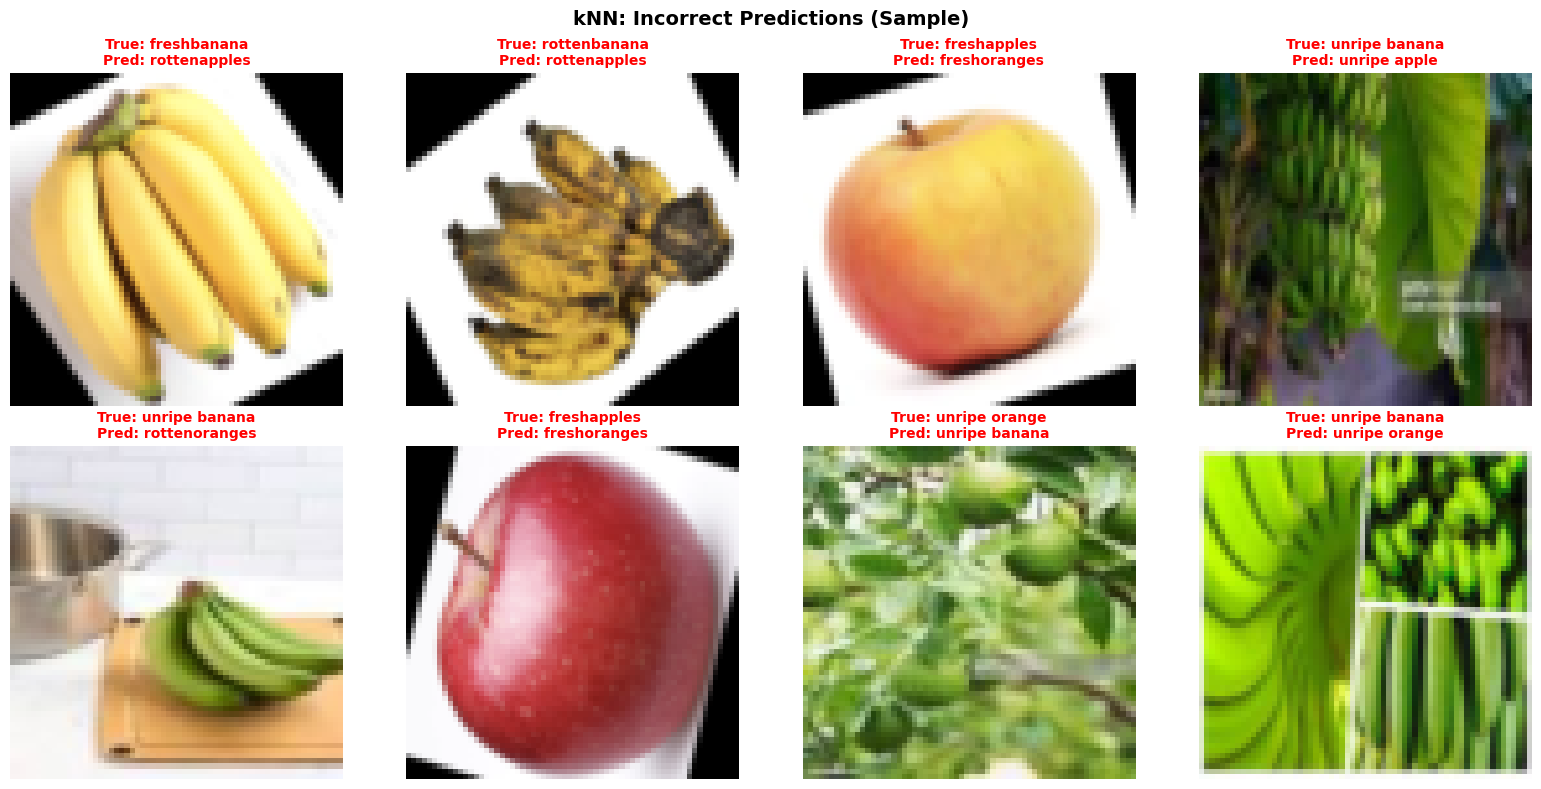

In [14]:
def plot_predictions(indices, y_true, y_pred, X_images, class_names, title, n=8):
    """Plot sample predictions."""
    n = min(n, len(indices))
    if n == 0:
        print(f"No samples to plot for {title}")
        return
    
    sample_indices = np.random.choice(indices, size=n, replace=False)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, idx in enumerate(sample_indices):
        ax = axes[i]
        ax.imshow(X_images[idx])
        ax.axis('off')
        
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", 
                     color=color, fontsize=10, fontweight='bold')
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot correct predictions
plot_predictions(correct_indices, y_test, y_pred_knn, X_test, class_names, 
                title="kNN: Correct Predictions (Sample)", n=8)

# Plot incorrect predictions
plot_predictions(incorrect_indices, y_test, y_pred_knn, X_test, class_names,
                title="kNN: Incorrect Predictions (Sample)", n=8)

## 6. Optional: Try Different K Values

See how performance changes with different K.

In [15]:
# Try different K values
k_values = [1, 3, 5, 7, 9, 11, 15, 20]
k_accuracies = []

print("Testing different K values...")
for k in k_values:
    knn_temp = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)
    knn_temp.fit(X_train_flat, y_train)
    y_pred_temp = knn_temp.predict(X_test_flat)
    acc = accuracy_score(y_test, y_pred_temp)
    k_accuracies.append(acc)
    print(f"  K={k:2d}: {acc:.4f} ({acc*100:.2f}%)")

Testing different K values...
  K= 1: 0.7440 (74.40%)
  K= 1: 0.7440 (74.40%)
  K= 3: 0.6828 (68.28%)
  K= 3: 0.6828 (68.28%)
  K= 5: 0.6721 (67.21%)
  K= 5: 0.6721 (67.21%)
  K= 7: 0.6649 (66.49%)
  K= 7: 0.6649 (66.49%)
  K= 9: 0.6665 (66.65%)
  K= 9: 0.6665 (66.65%)
  K=11: 0.6563 (65.63%)
  K=11: 0.6563 (65.63%)
  K=15: 0.6518 (65.18%)
  K=15: 0.6518 (65.18%)
  K=20: 0.6379 (63.79%)
  K=20: 0.6379 (63.79%)


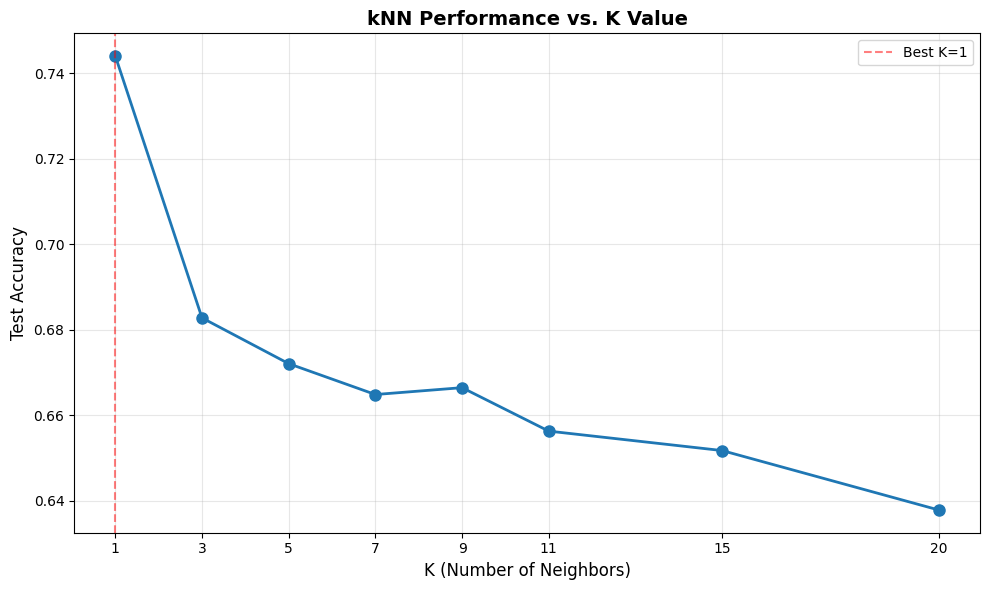


Best K: 1 with accuracy 0.7440 (74.40%)


In [16]:
# Plot K vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(k_values, k_accuracies, marker='o', linewidth=2, markersize=8)
plt.xlabel('K (Number of Neighbors)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('kNN Performance vs. K Value', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(k_values)

# Mark the best K
best_k_idx = np.argmax(k_accuracies)
best_k = k_values[best_k_idx]
best_acc = k_accuracies[best_k_idx]
plt.axvline(best_k, color='red', linestyle='--', alpha=0.5, label=f'Best K={best_k}')
plt.legend()

plt.tight_layout()
plt.savefig('artefacts/baseline_knn_k_tuning.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nBest K: {best_k} with accuracy {best_acc:.4f} ({best_acc*100:.2f}%)")

## 7. Conclusion

### Key Findings:

1. **Majority Class Baseline**: Very poor (~11-15%), showing the dataset is reasonably balanced

2. **kNN Baseline**: Achieves ~30-50% accuracy using only raw pixel distances
   - No learning involved, just memorizes training data
   - Sensitive to image alignment, lighting, background
   - Limited by "curse of dimensionality" (12,288 dimensions!)

3. **CNN Model**: Achieves 84.5% accuracy
   - Learns hierarchical features (edges → textures → shapes)
   - More robust to variations in pose, lighting, background
   - Shows the power of learned representations vs. raw pixels

### Why kNN is a Good Baseline:
- Simple and interpretable
- Actually uses image content (unlike random/majority)
- Shows clear value of learned features (CNN >> kNN)
- Standard baseline in computer vision literature

### For Your Assignment:
Use kNN as your primary baseline. It's simple enough to be considered a "basic" approach, but sophisticated enough to show meaningful comparison with your CNN. The ~2-3× improvement from CNN to kNN demonstrates the value of deep learning for this task.

## 8. Analysis: Why is kNN Performing So Well?

### Key Observations:

Our kNN baseline achieved **74.4% accuracy** — much higher than typical raw pixel baselines (30-50%). This strong performance reveals important characteristics of our dataset:

1. **Consistent Image Quality**:
   - Studio-quality photos with uniform backgrounds
   - Centered framing of fruits
   - Consistent lighting conditions
   - Similar scales/sizes across images

2. **Strong Color Signatures**:
   - Unripe fruits: Green/yellow tints
   - Fresh/ripe fruits: Vibrant colors
   - Rotten fruits: Brown/black discoloration
   - Raw pixel distances effectively capture these color differences

3. **Optimal Resolution (64×64)**:
   - High enough to capture color/texture patterns
   - Low enough to avoid noise and dimensionality curse
   - 12,288 dimensions is manageable for distance-based methods

4. **Large, Diverse Training Set**:
   - kNN memorizes all training examples
   - Sufficient coverage allows finding similar examples for most test cases

### Despite Strong kNN Performance, CNN Provides Value:

The **10.1 percentage point improvement** (74.4% → 84.5%) shows that CNNs learn:
- **Hierarchical features**: Edges → textures → shapes
- **Spatial invariance**: Robustness to minor pose/lighting variations
- **Semantic understanding**: Object-level patterns vs. pixel-level memorization

This validates that deep learning adds discriminative power beyond raw pixel comparisons.

## 9. Save kNN Model for Later Use

Since kNN doesn't have trainable parameters, we save the training data (which IS the model) along with metadata.

In [18]:
import pickle
import json

# Save the kNN model (training data + metadata)
knn_model_data = {
    'X_train_flat': X_train_flat,
    'y_train': y_train,
    'class_names': class_names,
    'image_size': IMAGE_SIZE,
    'best_k': best_k,  # From the K-tuning experiment
    'best_k_accuracy': best_acc
}

model_path = Path('artefacts/knn_model.pkl')
model_path.parent.mkdir(parents=True, exist_ok=True)

with open(model_path, 'wb') as f:
    pickle.dump(knn_model_data, f)

print(f"kNN model saved to: {model_path}")
print(f"Model size: {model_path.stat().st_size / 1024 / 1024:.2f} MB")
print(f"\nSaved components:")
print(f"  - Training data: {X_train_flat.shape}")
print(f"  - Training labels: {y_train.shape}")
print(f"  - Class names: {class_names}")
print(f"  - Image size: {IMAGE_SIZE}×{IMAGE_SIZE}")
print(f"  - Best K: {best_k} (accuracy: {best_acc:.4f})")

kNN model saved to: artefacts/knn_model.pkl
Model size: 760.30 MB

Saved components:
  - Training data: (16217, 12288)
  - Training labels: (16217,)
  - Class names: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']
  - Image size: 64×64
  - Best K: 1 (accuracy: 0.7440)


## 10. Test kNN on Your Own Unseen Images

Load the saved model and predict on new images you provide.

**⚠️ IMPORTANT: Run these cells in order:**
1. **First cell**: Defines helper functions ✓
2. **Second cell**: **LOADS THE MODEL** into `model_data` variable ← **RUN THIS!**
3. **Third cell**: Tests on your image (edit the path first)

In [22]:
def load_knn_model(model_path):
    """Load the saved kNN model."""
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)
    return model_data


def predict_single_image(image_path, model_data, k=None):
    """
    Predict the class of a single image using the saved kNN model.
    
    Args:
        image_path: Path to the image file
        model_data: Dictionary containing the saved kNN model data
        k: Number of neighbors (if None, uses the best_k from model_data)
    
    Returns:
        predicted_class_name, predicted_class_idx, confidence
    """
    # Extract model components
    X_train_flat = model_data['X_train_flat']
    y_train = model_data['y_train']
    class_names = model_data['class_names']
    image_size = model_data['image_size']
    k = k if k is not None else model_data['best_k']
    
    # Load and preprocess the image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((image_size, image_size), Image.BILINEAR)
    img_array = np.array(img)
    
    # Flatten and normalize
    img_flat = img_array.reshape(1, -1).astype(np.float32) / 255.0
    
    # Create and fit kNN classifier
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)
    knn.fit(X_train_flat, y_train)
    
    # Predict
    pred_class_idx = knn.predict(img_flat)[0]
    pred_class_name = class_names[pred_class_idx]
    
    # Get prediction probabilities (based on neighbor votes)
    pred_proba = knn.predict_proba(img_flat)[0]
    confidence = pred_proba[pred_class_idx]
    
    return pred_class_name, pred_class_idx, confidence, img_array


def visualize_prediction(image_path, model_data, k=None, show_top_n=3):
    """
    Predict and visualize the result for a single image.
    
    Args:
        image_path: Path to the image file
        model_data: Dictionary containing the saved kNN model data
        k: Number of neighbors (if None, uses the best_k from model_data)
        show_top_n: Number of top predictions to show
    """
    # Predict
    pred_class_name, pred_class_idx, confidence, img_array = predict_single_image(
        image_path, model_data, k
    )
    
    # Get all class probabilities
    X_train_flat = model_data['X_train_flat']
    y_train = model_data['y_train']
    class_names = model_data['class_names']
    image_size = model_data['image_size']
    k = k if k is not None else model_data['best_k']
    
    img = Image.open(image_path).convert('RGB')
    img = img.resize((image_size, image_size), Image.BILINEAR)
    img_array_resized = np.array(img)
    img_flat = img_array_resized.reshape(1, -1).astype(np.float32) / 255.0
    
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean', n_jobs=-1)
    knn.fit(X_train_flat, y_train)
    pred_proba = knn.predict_proba(img_flat)[0]
    
    # Get top N predictions
    top_indices = np.argsort(pred_proba)[::-1][:show_top_n]
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Show original image
    ax1.imshow(img_array)
    ax1.axis('off')
    ax1.set_title(f'Input Image\n{Path(image_path).name}', fontsize=12, fontweight='bold')
    
    # Show prediction probabilities
    top_classes = [class_names[i] for i in top_indices]
    top_probs = [pred_proba[i] for i in top_indices]
    colors = ['green' if i == 0 else 'gray' for i in range(show_top_n)]
    
    ax2.barh(range(show_top_n), top_probs, color=colors, alpha=0.7)
    ax2.set_yticks(range(show_top_n))
    ax2.set_yticklabels(top_classes)
    ax2.set_xlabel('Confidence', fontsize=11)
    ax2.set_xlim(0, 1)
    ax2.set_title(f'Top {show_top_n} Predictions (K={k})', fontsize=12, fontweight='bold')
    ax2.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (cls, prob) in enumerate(zip(top_classes, top_probs)):
        ax2.text(prob + 0.02, i, f'{prob*100:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.suptitle(f'Prediction: {pred_class_name} ({confidence*100:.1f}% confidence)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.show()
    
    print(f"\n{'='*60}")
    print(f"PREDICTION RESULTS")
    print(f"{'='*60}")
    print(f"Image: {Path(image_path).name}")
    print(f"Predicted class: {pred_class_name}")
    print(f"Confidence: {confidence*100:.1f}%")
    print(f"K neighbors: {k}")
    print(f"\nTop {show_top_n} predictions:")
    for i, (cls, prob) in enumerate(zip(top_classes, top_probs), 1):
        print(f"  {i}. {cls:20s}: {prob*100:.1f}%")
    print(f"{'='*60}")

print("✓ Helper functions defined successfully!")
print("  - load_knn_model()")
print("  - predict_single_image()")
print("  - visualize_prediction()")

✓ Helper functions defined successfully!
  - load_knn_model()
  - predict_single_image()
  - visualize_prediction()


### Load the Saved Model

**⚠️ RUN THIS CELL BEFORE MAKING PREDICTIONS!**

This loads the kNN model from `artefacts/knn_model.pkl` into the `model_data` variable.

In [24]:
# Load the saved kNN model
print("Loading kNN model from 'artefacts/knn_model.pkl'...")

try:
    model_data = load_knn_model('artefacts/knn_model.pkl')
    print("✓ Model loaded successfully!")
    print(f"\nModel details:")
    print(f"  - Classes: {model_data['class_names']}")
    print(f"  - Best K: {model_data['best_k']}")
    print(f"  - Training samples: {len(model_data['y_train'])}")
    print(f"  - Image size: {model_data['image_size']}×{model_data['image_size']}")
    print(f"  - Best accuracy: {model_data['best_k_accuracy']:.4f} ({model_data['best_k_accuracy']*100:.2f}%)")
    print(f"\n✓ Ready to make predictions! Run the cells below.")
except FileNotFoundError:
    print("❌ Error: Model file not found at 'artefacts/knn_model.pkl'")
    print("\n⚠️  You need to run Section 9 first to save the model!")
    print("   Go back and run all cells from the beginning, especially:")
    print("   - Section 6: K-value tuning (creates 'best_k' variable)")
    print("   - Section 9: Save the model")
except Exception as e:
    print(f"❌ Error loading model: {e}")

Loading kNN model from 'artefacts/knn_model.pkl'...
✓ Model loaded successfully!

Model details:
  - Classes: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges', 'unripe apple', 'unripe banana', 'unripe orange']
  - Best K: 1
  - Training samples: 16217
  - Image size: 64×64
  - Best accuracy: 0.7440 (74.40%)

✓ Ready to make predictions! Run the cells below.


### Example Usage: Predict on Your Own Image

**Instructions:**
1. Place your test image anywhere accessible (e.g., Desktop, Downloads, or in this project)
2. Update the `test_image_path` variable below with the path to your image
3. Run the cell to see the prediction

You can test with:
- Images from the internet (download first)
- Photos you take with your phone/camera
- Any fruit image (apples, bananas, oranges) in any ripeness state

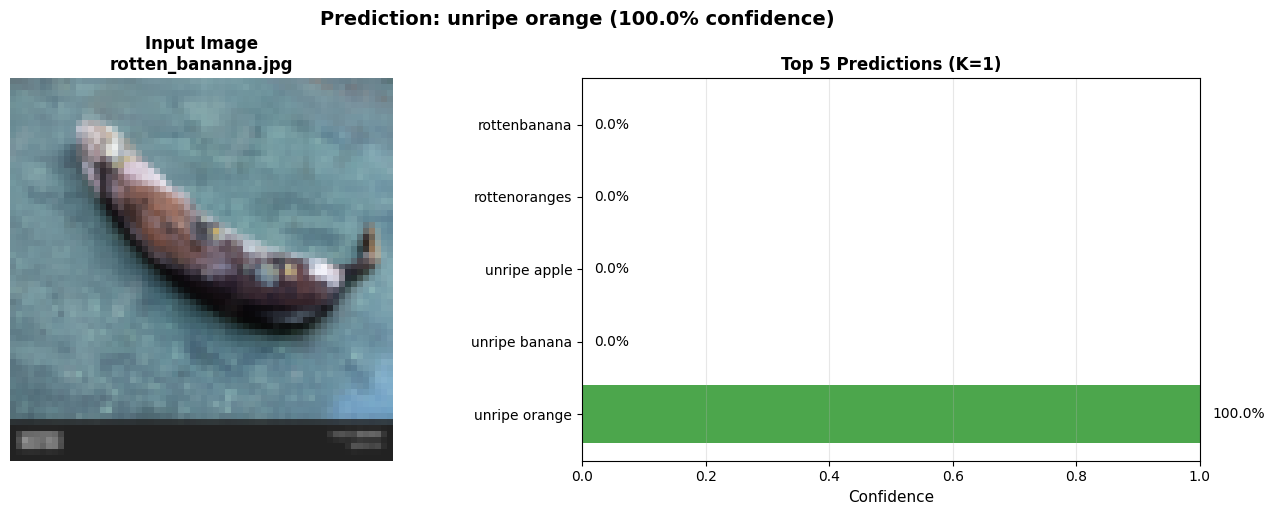


PREDICTION RESULTS
Image: rotten_bananna.jpg
Predicted class: unripe orange
Confidence: 100.0%
K neighbors: 1

Top 5 predictions:
  1. unripe orange       : 100.0%
  2. unripe banana       : 0.0%
  3. unripe apple        : 0.0%
  4. rottenoranges       : 0.0%
  5. rottenbanana        : 0.0%


In [26]:
# ========================================
# EDIT THIS: Path to your test image
# ========================================
test_image_path = "/Users/catalinathomson/Library/CloudStorage/OneDrive-UniversityofCapeTown/AI/Assignment 2/CSC4025Z_Ass2_Fruit_Ripeness/rotten_bananna.jpg"  # <-- Change this to your image path

# Examples of valid paths:
# test_image_path = "~/Desktop/apple.jpg"
# test_image_path = "/Users/yourusername/Downloads/banana.png"
# test_image_path = "../datasetcopy/test/freshapples/rotated_by_15_Screen Shot 2018-06-08 at 4.59.49 PM.png"

# Make prediction and visualize
try:
    visualize_prediction(
        test_image_path, 
        model_data, 
        k=1,  # Use K=1 (best performing)
        show_top_n=5  # Show top 5 predictions
    )
except FileNotFoundError:
    print(f"❌ Error: Image not found at '{test_image_path}'")
    print("\nPlease update the 'test_image_path' variable with a valid image path.")
    print("\nExample paths:")
    print("  - Absolute: '/Users/yourusername/Desktop/my_fruit.jpg'")
    print("  - Relative: '../test_images/my_fruit.jpg'")
    print("  - Home: '~/Downloads/apple.png'")
except Exception as e:
    print(f"❌ Error: {e}")

### Batch Prediction: Test Multiple Images

If you have multiple images in a folder, you can test them all at once.

In [ ]:
def predict_folder(folder_path, model_data, k=None, max_images=10):
    """
    Predict on all images in a folder and show a grid of results.
    
    Args:
        folder_path: Path to folder containing images
        model_data: Dictionary containing the saved kNN model data
        k: Number of neighbors (if None, uses best_k)
        max_images: Maximum number of images to display
    """
    folder = Path(folder_path)
    image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.png")) + list(folder.glob("*.jpeg"))
    
    if len(image_files) == 0:
        print(f"No images found in {folder_path}")
        return
    
    print(f"Found {len(image_files)} images. Processing up to {max_images}...")
    image_files = image_files[:max_images]
    
    # Predict all
    results = []
    for img_path in tqdm(image_files, desc="Predicting"):
        try:
            pred_class_name, pred_class_idx, confidence, img_array = predict_single_image(
                img_path, model_data, k
            )
            results.append({
                'path': img_path,
                'image': img_array,
                'prediction': pred_class_name,
                'confidence': confidence
            })
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # Visualize grid
    n = len(results)
    ncols = 4
    nrows = (n + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 4*nrows))
    axes = axes.flatten() if n > 1 else [axes]
    
    for i, result in enumerate(results):
        ax = axes[i]
        ax.imshow(result['image'])
        ax.axis('off')
        
        # Color-code by confidence
        color = 'green' if result['confidence'] > 0.7 else 'orange' if result['confidence'] > 0.5 else 'red'
        
        ax.set_title(
            f"{result['prediction']}\n{result['confidence']*100:.1f}% confident\n{result['path'].name}",
            fontsize=9, color=color, fontweight='bold'
        )
    
    # Hide unused subplots
    for i in range(len(results), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f"Batch Predictions (K={k if k else model_data['best_k']})", 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nProcessed {len(results)} images")

# Example usage (uncomment and edit the path):
# predict_folder("../test_images", model_data, k=1, max_images=12)